In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import altair as alt
from markdown import markdown
from IPython.display import Markdown
from ipywidgets.widgets import HTML, Tab
from ipywidgets import widgets
from datetime import timedelta
from matplotlib import pyplot as plt
from tqdm import tqdm
import os.path as op

from mod import load_data, alt_theme

In [2]:
def author_url(author):
    return f"https://github.com/{author}"

In [3]:
bot_names = pd.read_csv('./bot_names.csv')

In [4]:
fmt_date = "{:%Y-%m-%d}"

start_date = None
end_date = None

renderer = "jupyterlab"
github_orgs = ["jupyterhub", "jupyter", "jupyterlab", "jupyter-widgets", "ipython", "binder-examples", "nteract"]

In [5]:
alt.renderers.enable(renderer);
alt.themes.register('my_theme', alt_theme)
alt.themes.enable("my_theme")

ThemeRegistry.enable('my_theme')

In [5]:
comments, issues, prs = load_data('../data/', github_orgs=github_orgs)
comments = comments.query('author not in @bot_names')
issues = issues.query('author not in @bot_names')
prs = prs.query('author not in @bot_names')

In [6]:
# Load data from all the orgs that we've listed
comments = []
issues = []
prs = []
path_data_root = op.join('..', 'data')
for org in github_orgs:
    path_data = op.join(path_data_root, org)
    if not op.isdir(path_data):
        print(f"No data for {org}")
        continue
    comments.append(pd.read_csv(op.join(path_data, 'comments.csv'), index_col=0).query('author not in @bot_names'))
    issues.append(pd.read_csv(op.join(path_data, 'issues.csv'), index_col=0).query('author not in @bot_names'))
    prs.append(pd.read_csv(op.join(path_data, 'prs.csv'), index_col=0).query('author not in @bot_names'))
    
comments = pd.concat(comments)
issues = pd.concat(issues)
prs = pd.concat(prs)

In [7]:
if start_date is None:
    start_date = comments['updatedAt'].min()
    
if end_date is None:
    end_date = comments['updatedAt'].max()

In [9]:
# Information about out time window
time_delta = pd.to_datetime(end_date) - pd.to_datetime(start_date)
n_days = time_delta.days

# Information about the data we loaded
github_orgs = comments['org'].unique()

In [10]:
def highlighted_line_plot(data, x, y, color, title, domain=["2019-05-01", "2019-08-01"], legend=True):
    ch = alt.Chart(data=data, width=1000, title=title)

    highlight = alt.selection(type='single', on='mouseover',
                              fields=[color], nearest=True)

    ln = ch.mark_line(clip=True).encode(
        x=alt.X(x, scale=alt.Scale(domain=domain)),
        y=y,
        color=alt.Color(color, legend=legend),
        opacity=alt.condition(~highlight, alt.value(.5), alt.value(1)),
        size=alt.condition(~highlight, alt.value(2), alt.value(5))
    )

    pt = ch.mark_point(clip=True).encode(
        x=alt.X(x, scale=alt.Scale(domain=domain)),
        y=y,
        color=alt.Color(color, legend=legend),
        tooltip=color,
        size=alt.value(300),
        opacity=alt.value(0)
    ).add_selection(highlight).interactive()
    return ln + pt

In [11]:
date_fields = ['updatedAt', 'createdAt', 'closedAt']
for field in date_fields:
    if field in comments.columns:
        comments[field] = pd.to_datetime(comments[field])
    if field in prs.columns:
            prs[field] = pd.to_datetime(prs[field])
    if field in issues.columns:
            issues[field] = pd.to_datetime(issues[field])

## Comments over time by people

In [12]:
time_bin = '2W'
n_authors = 20
rolling_mean_amt = 4

jupyterhub
jupyter
jupyterlab
jupyter-widgets
ipython
binder-examples
nteract


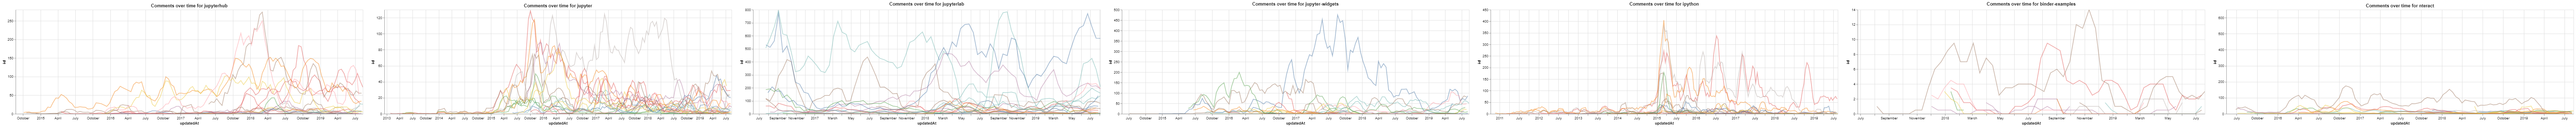

In [13]:
charts = []
for iorg in github_orgs:
    print(iorg)
    icomments = comments.query('org == @iorg')
    authors = icomments.groupby(['author', 'updatedAt']).agg({'id': 'count'}).reset_index()

    top_authors = authors.groupby('author').sum()['id'].sort_values(ascending=False).head(n_authors).index
    authors = authors.query('author in @top_authors')
    authors = authors.groupby('author').resample(time_bin, on='updatedAt').sum().reset_index()
    authors = authors.groupby('author').rolling(rolling_mean_amt, on='updatedAt').mean().reset_index()
    domain = [fmt_date.format(authors['updatedAt'].min()), fmt_date.format(authors['updatedAt'].max())]
    ch = highlighted_line_plot(authors, 'updatedAt', 'id', 'author', f"Comments over time for {iorg}",
                               legend=None, domain=domain)
    charts.append(ch)
alt.hconcat(*charts)

## Comments over time by repo

In [14]:
time_bin = '2W'
n_repos = 30
rolling_mean_amt = 2

jupyterhub
jupyter
jupyterlab
jupyter-widgets
ipython
binder-examples
nteract


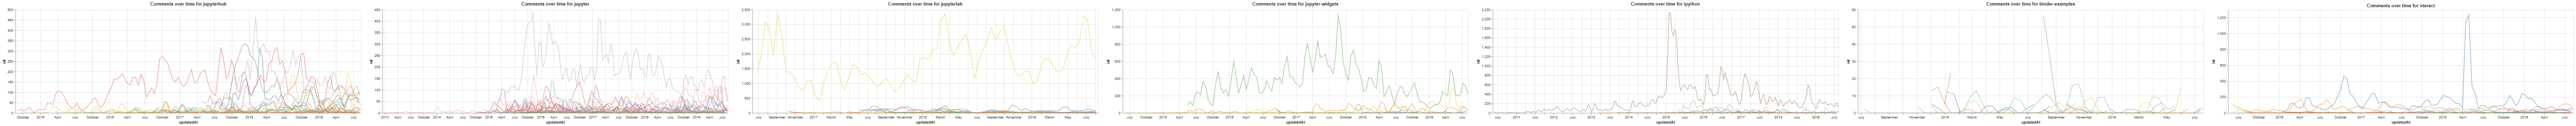

In [15]:
charts = []
for iorg in github_orgs:
    print(iorg)
    icomments = comments.query('org == @iorg')
    repos = icomments.groupby(['repo', 'updatedAt']).agg({'id': 'count'}).reset_index()

    top_repos = repos.groupby('repo').sum()['id'].sort_values(ascending=False).head(n_repos).index
    repos = repos.query('repo in @top_repos')
    repos = repos.groupby('repo').resample(time_bin, on='updatedAt').sum().reset_index()
    repos = repos.groupby('repo').rolling(rolling_mean_amt, on='updatedAt').mean().reset_index()
    domain = [fmt_date.format(repos['updatedAt'].min()), fmt_date.format(repos['updatedAt'].max())]
    ch = highlighted_line_plot(repos, 'updatedAt', 'id', 'repo', f"Comments over time for {iorg}",
                               legend=None, domain=domain)
    charts.append(ch)
alt.hconcat(*charts)

### Activity over time in each organization

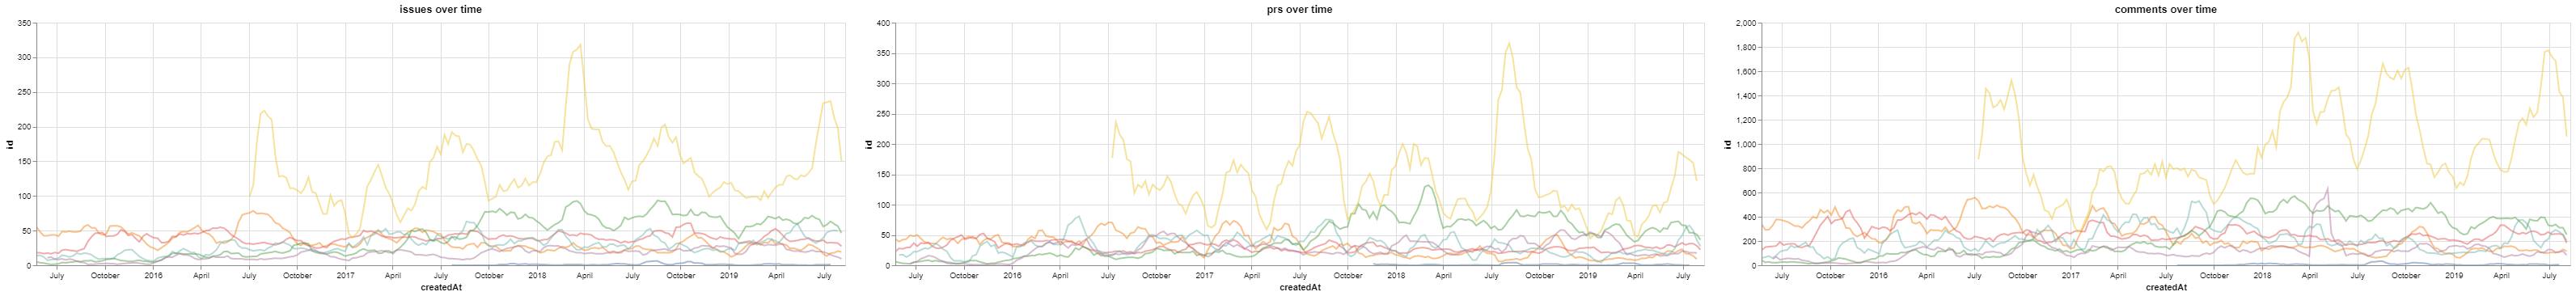

In [104]:
charts = []

for kind, idata in [('issues', issues), ('prs', prs), ('comments', comments)]:
    org_comments = idata.groupby('org').resample('W', on='createdAt').count()['id'].reset_index()
    org_comments = org_comments.groupby('org').rolling(5, on='createdAt').mean().reset_index()

    ch = highlighted_line_plot(org_comments, 'createdAt', 'id', 'org', f"{kind} over time", legend=None, domain=domain)
    charts.append(ch)
alt.hconcat(*charts)

## Time to first response of issues

In [16]:
first_comments = (
    comments.groupby(['org', 'repo', 'issue_id'], as_index=False)                 
    .agg({'id': 'first', 'createdAt': 'first'})
    .rename(columns={'createdAt': 'firstResponse', 'issue_id': 'number'})
    .drop(columns='id')
)

In [17]:
issues_w_response = pd.merge(first_comments, issues, on=['org', 'repo', 'number'])
issues_w_response[['createdAt', 'firstResponse']] = issues_w_response[['createdAt', 'firstResponse']].apply(pd.to_datetime)

In [18]:
issues_w_response['time_to_first_response'] = issues_w_response['firstResponse'] - issues_w_response['createdAt']
issues_w_response['hours_to_first_response'] = issues_w_response['time_to_first_response'].map(lambda a: 24 * a.days + a.seconds / 60 / 60)

jupyterhub
jupyter
jupyterlab
jupyter-widgets
ipython
binder-examples
nteract


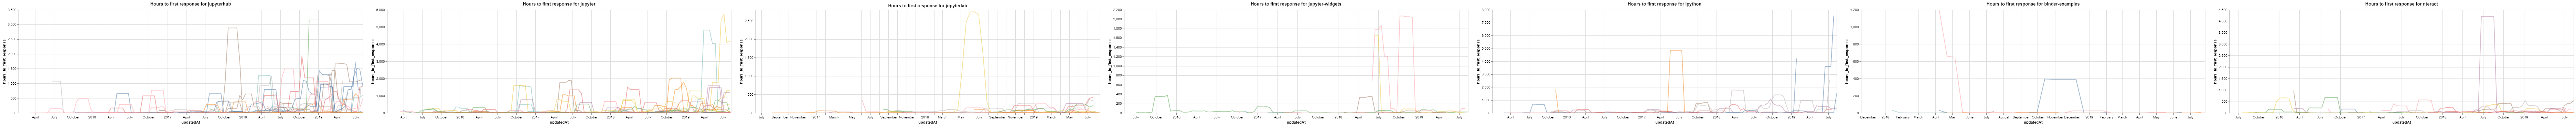

In [19]:
charts = []
for iorg in github_orgs:
    print(iorg)
    i_issues = issues_w_response.query('org == @iorg')
    repo_comments = (
        i_issues.groupby('repo')
        .resample(time_bin, on='updatedAt').median()['hours_to_first_response']
        .reset_index()
        .replace(np.nan, 0)
        .groupby('repo').rolling(5, on='updatedAt').mean().reset_index('repo')
    )

    n_plot = 20
    top_repos = repo_comments.groupby('repo').count()['hours_to_first_response'].sort_values(ascending=False).head(n_plot).index.values
    repo_comments = repo_comments.query('repo in @top_repos')
    domain = [fmt_date.format(repo_comments['updatedAt'].min()), fmt_date.format(repo_comments['updatedAt'].max())]
    ch = highlighted_line_plot(repo_comments, 'updatedAt', 'hours_to_first_response', 'repo', f"Hours to first response for {iorg}",
                               legend=None, domain=domain)
    charts.append(ch)
alt.hconcat(*charts)

In [ ]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>